In [72]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.ops.math_ops import reduce_prod
from tensorflow.math import reduce_prod

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

In [73]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# # load train, test, and validation datasets
# train_files, train_targets = load_dataset('../../../data/dog_images/train')
# valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
# test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
# dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]
dog_names = [item[20:-1] for item in sorted(glob('dogImages/train/*/'))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [74]:
train_dir = 'dogImages/train'
validation_dir = 'dogImages/valid'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 6680 files belonging to 133 classes.


In [75]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 835 files belonging to 133 classes.


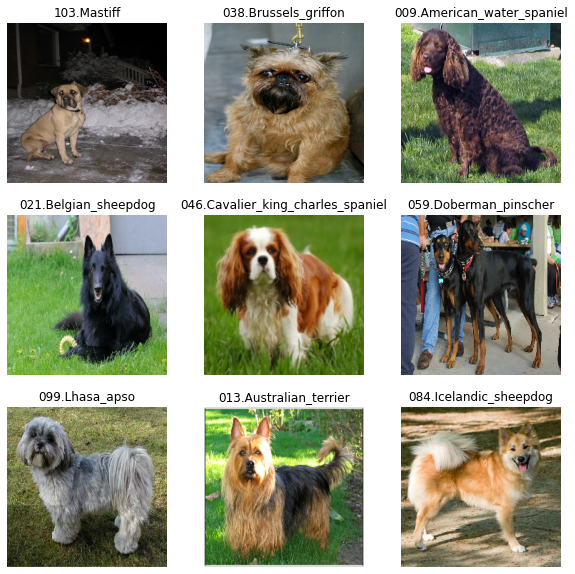

In [76]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [77]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [78]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 22
Number of test batches: 5


In [97]:
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [98]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')
valid_tensors = paths_to_tensor(valid_files).astype('float32')
test_tensors = paths_to_tensor(test_files).astype('float32')

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:12<00:00, 64.50it/s]


In [79]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [99]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

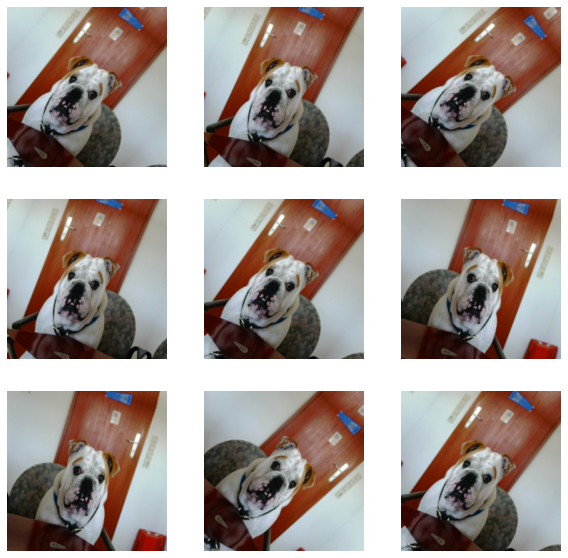

In [100]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [101]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [102]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [103]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.Xception(
    weights='imagenet',  
    input_shape=IMG_SHAPE,
    include_top=False)


In [104]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [105]:
base_model.trainable = False

In [106]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [107]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [108]:
prediction_layer = tf.keras.layers.Dense(133,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 133)


In [118]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = tf.keras.layers.Flatten(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [119]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [120]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_8 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_8 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0   

In [121]:
len(model.trainable_variables)

2

In [123]:
initial_epochs = 5


In [127]:
# Train the model
# # checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
#                                verbose=1, save_best_only=True)

history = model.fit(train_tensors, train_targets, 
                  validation_data=(valid_tensors, valid_targets),
                  epochs=initial_epochs, batch_size=20,  verbose=1)

Epoch 1/5
 82/334 [======>.......................] - ETA: 44s - loss: 1.4130 - accuracy: 0.6768

KeyboardInterrupt: 

In [41]:
train_Xception.shape

(6680, 7, 7, 2048)

In [36]:
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']


In [ ]:
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
# Inception_model.add(Dropout(0.4))
# Inception_model.add(Dense(512, activation='relu'))
# Xception_model.add(Dropout(0.4))
# Xception_model.add(Dense(256, activation='relu'))
Xception_model.add(Dropout(0.4))
Xception_model.add(Dense(133, activation='softmax'))

# Train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

history = Xception_model.fit(train_Xception, train_targets, 
                  validation_data=(valid_Xception, valid_targets),
                  epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)